<h3 style="text-align:center">Logistic Regression with Iris dataset</h3>

In this notebook we will build a logistic regression classifier applied to the well-known iris dataset.

<h3><u>Packages</u></h3>

First, let's import all the packages that we will need to complete our goal:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# remove warnings
import warnings
warnings.filterwarnings('ignore')

<h3><u>Analyze data</u></h3>

In this part, we will open and investigate the dataset so that we can understand it.

In [2]:
# Load dataset
data = pd.read_csv('iris.csv')

In [3]:
# Peek at the first 5 values:
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Investigate species
data.groupby('Species').size()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

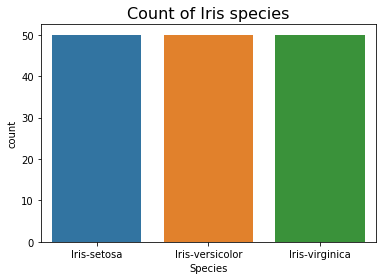

In [5]:
sns.countplot(x='Species', data=data)
plt.title('Count of Iris species', size=16)
plt.show()


From these observations, we can infer that the iris dataset includes 3 iris species with 50 samples each and we have 4 columns that allows to distinguish the species: <br>
<ul>
    <li>SepalLengthCm</li>
    <li>SepalWidthCm</li>
    <li>PetalLengthCm</li>
    <li>PetalWidthCm</li>
</ul>
These names are self-explanatory and are characteristics of the flowers that had been measured and then labeled.

<h3><u>Create validation dataset</u></h3>

We need to know whether or not our model is good or not. <br>

For that, we need to know how the model will behave on <u>unseen data</u>. As such, we are going to hold back some data that the algorithm will not get to see and wwe will use this data to get a second and independent idea of how accurate our model actually is.<br>

We will split the loaded dataset into two, <b>80%</b> of which we will use to train our model and <b>20%</b> that we will hold back as a validation dataset.

In [6]:
np.random.seed(42) # To make output consistent in this notebook

In [7]:
def split_train_validation(data, validation_ratio):
    shuffled_indices = np.random.permutation(len(data))
    validation_set_size = int(len(data) * validation_ratio)
    validation_indices = shuffled_indices[:validation_set_size]
    train_indices = shuffled_indices[validation_set_size:]
    return data.iloc[train_indices], data.iloc[validation_indices]

In [8]:
validation_ratio = 0.2
train, validation = split_train_validation(data, validation_ratio)
print("train size:", len(train), "validation_size", len(validation))

train size: 120 validation_size 30


In [9]:
train.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
22,23,4.6,3.6,1.0,0.2,Iris-setosa
15,16,5.7,4.4,1.5,0.4,Iris-setosa
65,66,6.7,3.1,4.4,1.4,Iris-versicolor
11,12,4.8,3.4,1.6,0.2,Iris-setosa
42,43,4.4,3.2,1.3,0.2,Iris-setosa


With this function, we've made sure that not all the iris virginica remains in the validation dataset by picking the instances randomly.

We need to split the resulting sets into 2 parts again:<br>
<ul>
    <li>The features: These are the data that the machine need to hae in order to learn patterns</li>
    <li>The labels: They are what the machine need to find by itself after being trained</li>

In [10]:
X_train, y_train = train.iloc[:, 1:5], train.iloc[:, 5]
X_valid, y_valid = validation.iloc[:, 1:5], validation.iloc[:, 5]

In [11]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(120, 4) (120,)
(30, 4) (30,)


For convenience, we will transform y_train and y_valid which are 1-dimensional arrays into 2-dimensional arrays.

In [12]:
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)

In [13]:
# Verify shapes
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(120, 4) (120, 1)
(30, 4) (30, 1)


Objective:

We will build a classifier to detect the Iris-Virginica type based only on the petal width feature

In [12]:
# X_train_virg = X_train.iloc[:, 3]
# X_valid_virg = X_valid.iloc[:, 3]
# X_train_virg = X_train
# X_valid_virg = X_valid

In [15]:
y_train_virg = np.where(y_train=='Iris-setosa', 1, 0)
y_valid_virg = np.where(y_valid=='Iris-setosa', 1, 0)

In [16]:
print(y_train_virg.shape)
print(y_valid_virg.shape)

(120, 1)
(30, 1)


<h3><u>Mathematical expression of the algorithm</u></h3>

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)}  $$
$$\hat{p}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
  
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

<h3><u>Building the parts of the algorithm</u></h3>

<u>Sigmoid function</u>

The logistic function, also called <u>sigmoid</u> needs to be impletemented:
$$\sigma(t)=\frac{1}{1 + exp(-t)}$$

In [49]:
def logistic_func(theta, x):
    return 1.0 / (1 + np.exp(-np.dot(x, theta)))

<u>Initialize parameter<u>

We initialize w as a vector of zeros

In [50]:
def init_parameter(X):
    shape = X.shape[1] # number of features
    w = np.zeros((shape, 1))
    
    return w

<u>Compute cost function</u>

In [51]:
def cost_func(theta, x, y):
    h = logistic_func(theta, x)
    y = np.squeeze(y)
#     step1 = y * np.log(h)
#     step2 = (1-y) * np.log(1-h)
#     final = -step1 - step2
    cost = -y * np.log(h) - (1-y) * np.log(1-h)
    
    return np.mean(cost)

In [52]:
W = np.zeros(4)
cost = cost_func(W, X_train, y_train_virg)
cost

0.69314718055994529

<u>Gradient computation</u>

In [70]:
def log_gradient(theta, x, y):
    first_calc = logistic_func(theta, x) - np.squeeze(y)
    final_calc = np.dot(first_calc.T, x)
    return final_calc

<u>Gradient Descent</u>

In [86]:
def grad_desc(theta_values, X, y, learning_rate=0.001, converge_change=0.001):
    # Normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    # Setup cost iter
    cost_iter = []
    cost = cost_func(theta_values, X, y)
#     print("cost shape:", cost.shape)
    cost_iter.append([0, cost])
    change_cost = 1
    i = 1
    while (change_cost > converge_change):
        old_cost = cost
        theta_values = theta_values - (learning_rate * log_gradient(theta_values, X, y))
        cost = cost_func(theta_values, X, y)
        cost_iter.append([i, cost])
        change_cost = old_cost - cost
        i += 1
    return theta_values, np.array(cost_iter)

<u>Predict values</u>

In [87]:
def pred_values(theta, X, hard=True):
    # normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    pred_prob = logistic_func(theta, X)
    pred_value = np.where(pred_prob >= 0.5, 1, 0)
    if hard: 
        return pred_value
    return pred_prob

<h3>Testing algorthm</h3>

In [88]:
shape = X_train.shape[1]
W = np.zeros((shape))
fitted_values, cost_iter = grad_desc(W, X_train, y_train_virg)
print(fitted_values)

[-0.61793839  0.94491107 -1.03537297 -0.97082404]


In [79]:
predicted_y = pred_values(fitted_values, X_train, hard=True)
predicted_y

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0])

In [83]:
np.sum(np.squeeze(y_train_virg) == predicted_y)

120

The algorithm detected all the Iris-Virginica on the train set ! 

<h3>Evaluate on validation set</h3>

In [89]:
predicted_y_valid = logistic_func(fitted_values, X_valid)

In [93]:
predicted_y_valid = pred_values(fitted_values, X_valid)
predicted_y_valid

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1])

In [94]:
np.sum(np.squeeze(y_valid_virg) == predicted_y_valid)

29

Not bad! Out of the 30 examples on the validation set, 29 were classified correctly